In [1]:
import copy

import pandas as pd
import numpy as np
import optuna
import xgboost
import imblearn.over_sampling
import sklearn.model_selection
import dscribe.descriptors
import tqdm
import sklearn.pipeline
import sklearn.feature_selection
import pymatgen.io.ase
import pymatgen.symmetry.analyzer
import functools

import matplotlib.pyplot as plt
import sklearn.impute
import seaborn as sns

import sys
sys.path.append("../../../")
import DigitalEcosystem.utils.figures
from DigitalEcosystem.utils.misc import noble_gases, fblock, d_synths, matminer_descriptors

tqdm.tqdm.pandas()

In [2]:
# Random seeds for reproducibility
RANDOM_SEED = 1234
import random
random.seed(RANDOM_SEED)
np.random.seed(RANDOM_SEED)

In [3]:
# Load up the data
data_path = "../../refined/httpot/full_featurized_data.pkl"
data = pd.read_pickle(data_path).fillna(0)

In [4]:
bad_elements = noble_gases + fblock + d_synths

element_mask = data['atoms_object (unitless)'].apply(lambda atoms: all([forbidden not in atoms.get_chemical_symbols() for forbidden in bad_elements]))

decomposition_mask = data['decomposition_energy (eV/atom)'] < 0.5

exfoliation_mask = data['exfoliation_energy_per_atom (eV/atom)'] > 0

reasonable = data[element_mask & decomposition_mask & exfoliation_mask]

In [5]:
pymatgen_objs = reasonable['atoms_object (unitless)'].progress_apply(pymatgen.io.ase.AseAtomsAdaptor.get_structure)
spacegroups = pymatgen_objs.progress_apply(lambda structure: pymatgen.symmetry.analyzer.SpacegroupAnalyzer(structure).get_space_group_number())

100%|██████████| 3511/3511 [00:02<00:00, 1355.10it/s]


In [6]:
max_bitlength = spacegroups.apply(lambda num: num.bit_length()).max()
bins = spacegroups.apply(lambda sg: np.base_repr(sg, base=2, padding=max_bitlength-sg.bit_length()))

spacegroup_colnames = [f'spacegroup_bit_{2**i}' for i in range(max_bitlength)]
reasonable[spacegroup_colnames] = bins.apply(list).apply(lambda lst: list(map(int,lst))).to_list()

/Users/mat3ra/sisso_collab/.env/lib/python3.9/site-packages/pandas/core/frame.py:3673: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[col] = igetitem(value, i)


In [7]:
target_column = ['exfoliation_energy_per_atom (eV/atom)']

In [8]:
xenonpy_descriptors = [col for col in data.columns if ":" in col]
xenonpy_matminer_descriptors = xenonpy_descriptors + matminer_descriptors

In [9]:
graph_descriptors = list(filter(lambda colname: any(i in colname for i in ["(bonds)", "(angles)", "(atoms)"]), reasonable.columns))

In [10]:
train, test = sklearn.model_selection.train_test_split(reasonable, test_size=0.1, random_state=RANDOM_SEED)

In [11]:
train_x_regression = np.nan_to_num(train[xenonpy_matminer_descriptors + spacegroup_colnames].to_numpy())
train_y_regression = np.nan_to_num(train[target_column].to_numpy())

test_x_regression = np.nan_to_num(test[xenonpy_matminer_descriptors + spacegroup_colnames].to_numpy())
test_y_regression = np.nan_to_num(test[target_column].to_numpy())

In [12]:
import sklearn.linear_model

current_regression = None
best_regression = None
def keep_best_regression(study, trial):
    global best_regression
    if study.best_trial == trial:
        best_regression = current_regression

objective_train_x_regression, objective_validation_x_regression, objective_train_y_regression, objective_validation_y_regression = sklearn.model_selection.train_test_split(
    np.nan_to_num(train_x_regression), train_y_regression, test_size=0.1, random_state=RANDOM_SEED)

def objective(trial: optuna.Trial):
    global current_regression

    current_regression = sklearn.pipeline.Pipeline([
        ("Scaler", sklearn.preprocessing.MinMaxScaler()),
        ("XGB_Regressor", xgboost.sklearn.XGBRegressor(
            max_depth= trial.suggest_int('max_depth', 1, 100),
            min_child_weight= trial.suggest_float('min_child_weight', 0, 10),
            reg_alpha = trial.suggest_float('alpha', 0, 5),
            reg_lambda = trial.suggest_float('lambda', 0, 5),
            n_estimators=200,
            objective='reg:squarederror',
            random_state=RANDOM_SEED),),
    ])

    pruning_callback = optuna.integration.XGBoostPruningCallback(trial, f'validation_0-rmse')
    current_regression.fit(X=objective_train_x_regression, y=objective_train_y_regression,
                         **{
                            'XGB_Regressor__eval_set': [[objective_validation_x_regression, objective_validation_y_regression]],
                            'XGB_Regressor__eval_metric': 'rmse',
                            'XGB_Regressor__early_stopping_rounds': 10,
                            'XGB_Regressor__callbacks': [pruning_callback],
                            'XGB_Regressor__verbose': False
                         })

    score = sklearn.metrics.mean_squared_error(
        y_true=objective_validation_y_regression,
        y_pred=abs(current_regression.predict(objective_validation_x_regression)),
    )

    return np.sqrt(score)

regression_study = optuna.create_study(
    sampler = optuna.samplers.TPESampler(
        seed = RANDOM_SEED,
        warn_independent_sampling = True,
        consider_endpoints = True
    ),
    pruner = optuna.pruners.HyperbandPruner(
        min_resource=1,
        max_resource=100),
    direction='minimize'
)

regression_study.optimize(func=objective, n_trials=256, callbacks=[keep_best_regression])

[I 2021-08-26 12:58:23,825] A new study created in memory with name: no-name-808cb84e-d846-4c79-9729-184100e82be6
[I 2021-08-26 12:58:24,748] Trial 0 finished with value: 0.06964896153378904 and parameters: {'max_depth': 20, 'min_child_weight': 6.221087710398319, 'alpha': 2.1886386950355723, 'lambda': 3.926792918568846}. Best is trial 0 with value: 0.06964896153378904.
[I 2021-08-26 12:58:24,807] Trial 1 pruned. Trial was pruned at iteration 1.
[I 2021-08-26 12:58:24,859] Trial 2 pruned. Trial was pruned at iteration 1.
[I 2021-08-26 12:58:25,891] Trial 3 finished with value: 0.06645334344707016 and parameters: {'max_depth': 69, 'min_child_weight': 7.127020269829002, 'alpha': 1.8512537739519748, 'lambda': 2.8059809303281247}. Best is trial 3 with value: 0.06645334344707016.
[I 2021-08-26 12:58:25,969] Trial 4 pruned. Trial was pruned at iteration 1.
[I 2021-08-26 12:58:26,965] Trial 5 finished with value: 0.06892179544518202 and parameters: {'max_depth': 37, 'min_child_weight': 6.15396

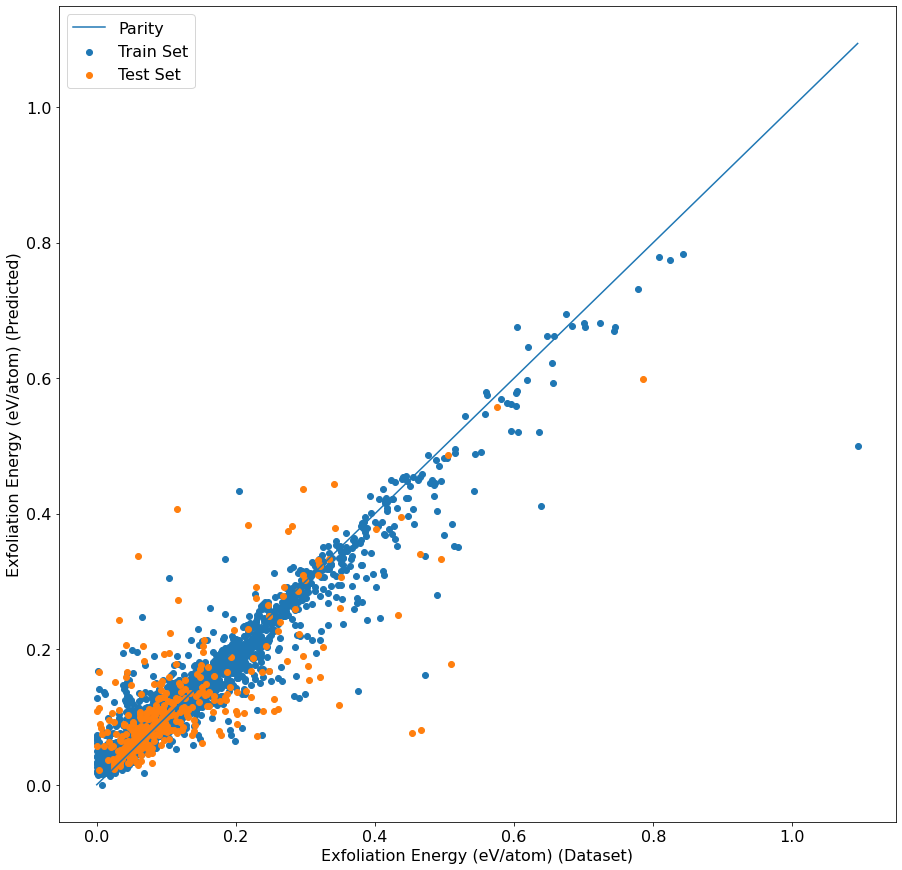

In [13]:
DigitalEcosystem.utils.figures.save_parity_plot(train_x_regression,
                                                test_x_regression,
                                                train_y_regression,
                                                test_y_regression,
                                                best_regression,
                                                "Exfoliation Energy (eV/atom)",
                                                "exfoliation_parity.jpeg")

In [14]:
def rmse(y_true, y_pred):
    mse = sklearn.metrics.mean_squared_error(y_true=y_true, y_pred=y_pred)
    rmse = np.sqrt(abs(mse))
    return rmse

metrics = {
    'MaxError': sklearn.metrics.max_error,
    'MAE': sklearn.metrics.mean_absolute_error,
    'MSE': sklearn.metrics.mean_squared_error,
    'RMSE': rmse,
    'MAPE': sklearn.metrics.mean_absolute_percentage_error,
    'R2': sklearn.metrics.r2_score
}

y_pred_test = best_regression.predict(test_x_regression)
for key, fun in metrics.items():
    value = fun(y_true=test_y_regression, y_pred=y_pred_test)
    print(key,np.round(value,3))

MaxError 0.385
MAE 0.041
MSE 0.005
RMSE 0.068
MAPE 3.892
R2 0.583


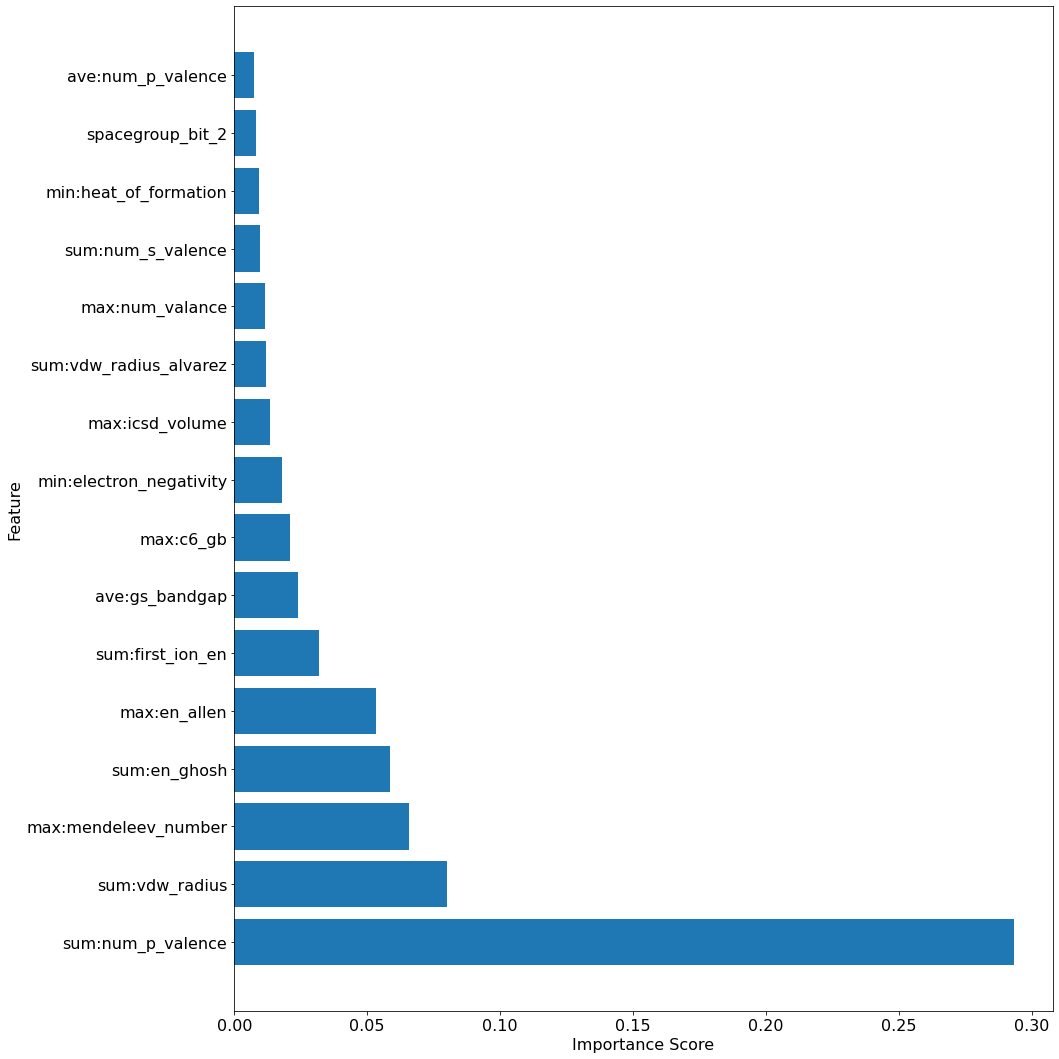

In [17]:
n_importances = 16
importances = list(zip(best_regression[1].feature_importances_, xenonpy_matminer_descriptors+spacegroup_colnames))

sorted_importances = list(sorted(importances, key=lambda i: -i[0]))



plt.barh(range(n_importances), [imp[0] for imp in sorted_importances[:n_importances]])
plt.yticks(range(n_importances), [imp[1] for imp in sorted_importances[:n_importances]])
plt.ylabel("Feature")
plt.xlabel("Importance Score")
plt.tight_layout()
plt.savefig("sg_importances.jpeg")